In [5]:
!mv /Users/georgiyandreev/Downloads/2020_практикум-2_301_Андреев.xls ./

In [1]:
# Get data into dataframe
import pandas as pd
import numpy as np
import sys
read_df = pd.read_excel('2020_практикум-2_301_Андреев.xls', header=[0,1], na_values=['--']).dropna(thresh=2)
read_df.index = read_df['ABTS, 47.5 мкМ']['время'].round(1)
df = pd.DataFrame(columns=['ABTS, 6.3 мкМ', 'ABTS, 14.3 мкМ', 'ABTS, 47.5 мкМ'], index=read_df['ABTS, 47.5 мкМ']['время'].round(1), 
                  data=read_df.iloc[:, read_df.columns.get_level_values(1)=='продукт'].droplevel(1, axis=1))

[Text(0, 0.5, 'ABTSox, μmol'), Text(0.5, 0, 'Время, с')]

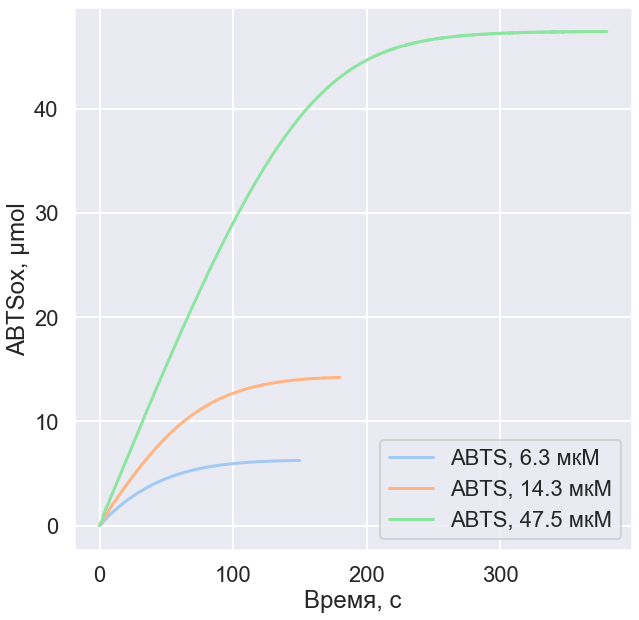

In [2]:
# В прямых координатах
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize

plt.figure(figsize=(10, 10))
sns.set_context("poster")
sns.set_style(style='darkgrid')
sns.set_palette('pastel')

fg1 = sns.lineplot(data=df, dashes=False)
fg1.set(ylabel='ABTSox, μmol', xlabel='Время, с')

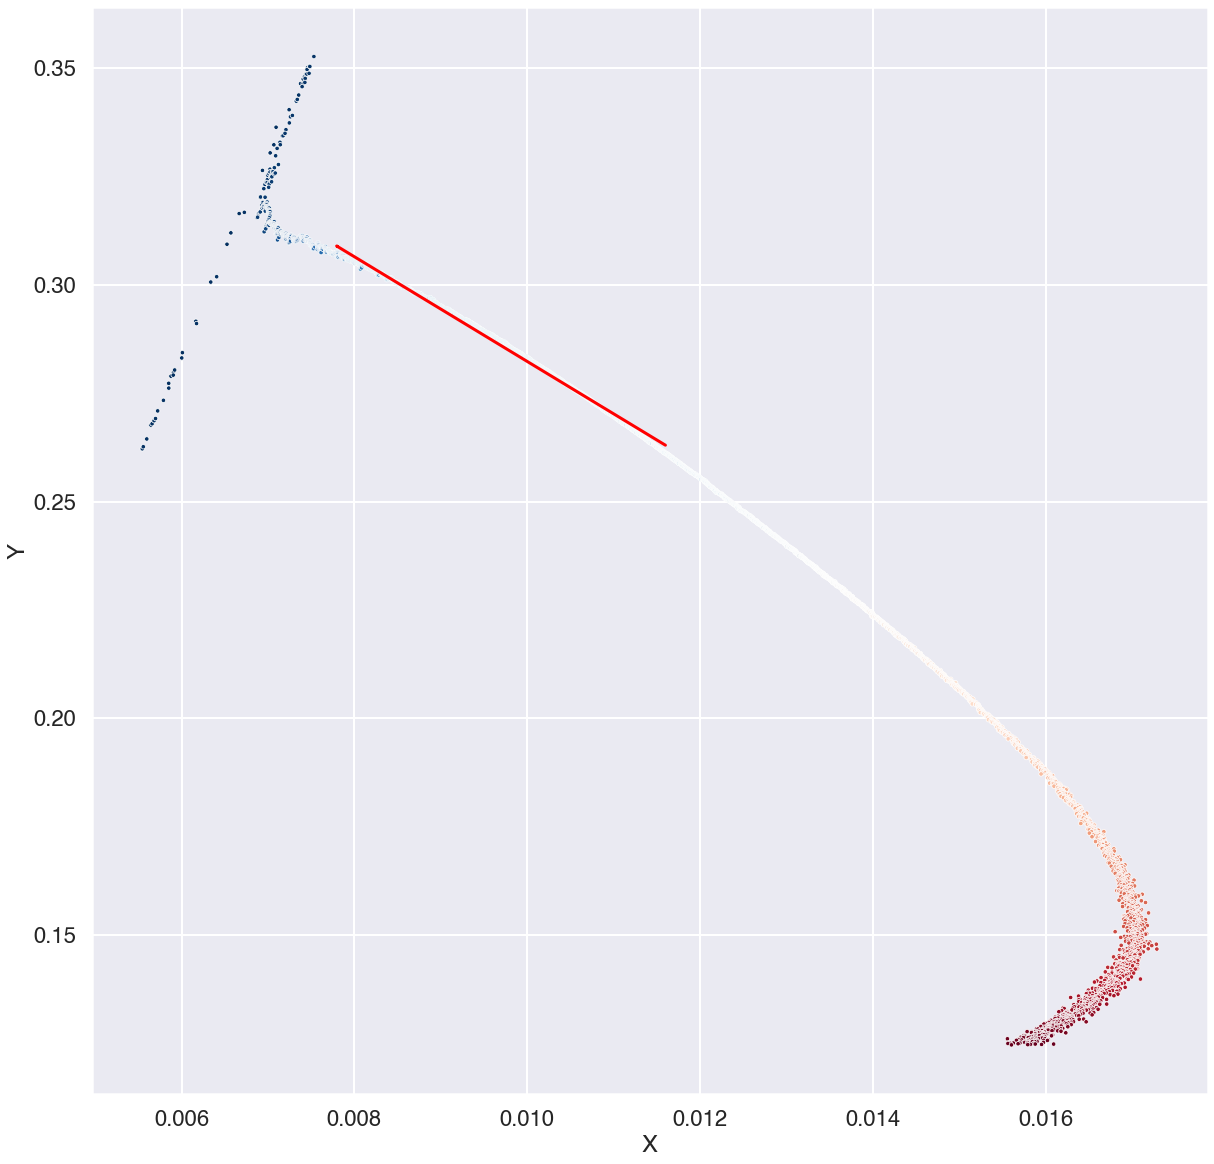

In [3]:
# В координатах Уокера-Шмидта
import seaborn as sns

def linear_func(x, a, b):
    return a + b*x

# Протестируем на одной из концентраций

S0 = 47.5
tP = df.iloc[:, 2].dropna()
t = tP.index.to_numpy()
t[0] = t[0] + 1e-5
P = tP.to_numpy()
S = S0 - P
X = np.log(S0/S) / t
Y = P / t
XYt = np.column_stack((t[1:], X[1:], Y[1:]))
XYt_df = pd.DataFrame(columns=['time', 'X', 'Y'], data=XYt)


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
plt.figure(figsize=(20, 20))
scat = sns.scatterplot(x = "X", y = "Y", data = XYt_df, hue = "time", palette = "RdBu_r", legend=None, s=20)
# plt.savefig('WS.png', dpi=300)
params, params_covariance = optimize.curve_fit(linear_func, X[500:1500], Y[500:1500])
scat.plot(X[500:1500], linear_func(X[500:1500], *params), c='r')

In [4]:
params, params_covariance = optimize.curve_fit(linear_func, X[200:1000], Y[200:1000])

# Задание 1

In [83]:
# Задание 1
from IPython.display import clear_output
from ipywidgets import interact

def walker_schmidt(Concentration):
    
    def extended(ax, x, y, **args):

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        x_ext = np.linspace(xlim[0], xlim[1], 100)
        p = np.polyfit(x, y , deg=1)
        y_ext = np.poly1d(p)(x_ext)
        ax.plot(x_ext, y_ext, **args)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        return ax
        
    S0 = Concentration
    if S0 == 6.3:
        first, second = (400, 800)
    elif S0 == 14.3:
        first, second = (600, 1000)
    elif S0 == 47.5:
        first, second = (500, 1500)
    tP = df[df.columns[df.columns.str.match(f'(.*{S0}.*)')]].dropna().squeeze()
    t = tP.index.to_numpy()
    t[0] = t[0] + 1e-5
    P = tP.to_numpy()
    S = S0 - P
    X = np.log(S0/S) / t
    Y = P / t
    XYt = np.column_stack((t[1:], X[1:], Y[1:]))
    XYt_df = pd.DataFrame(columns=['time', 'X', 'Y'], data=XYt)
    plt.figure(figsize=(15, 15))
    scat = sns.scatterplot(x = "X", y = "Y", data = XYt_df, hue = "time", palette = "RdBu_r", s=20)
    params, params_covariance = optimize.curve_fit(linear_func, X[first:second], Y[first:second])
    ax = plt.gca()
    ax = extended(ax, X[first:second], linear_func(X[first:second], *params),  color="r", lw=2)
    
    print("Fitted line with a = {:.3f}, b = {:.3f}".format(params[0], params[1]))

    
    return scat

In [84]:
interact(walker_schmidt, Concentration = [6.3, 14.3, 47.5])

interactive(children=(Dropdown(description='Concentration', options=(6.3, 14.3, 47.5), value=6.3), Output()), …

<function __main__.walker_schmidt(Concentration)>

In [102]:
# Задание 2
from IPython.display import clear_output

def non_linear(XX, a, b):
    X1, X2 = XX[:, 0], XX[:, 1]
    return (b/a) * X1 + (1/a) * X2

def walker_schmidt_nl(Concentration):
        
    S0 = Concentration
    tP = df[df.columns[df.columns.str.match(f'(.*{S0}.*)')]].dropna().squeeze()
    t = tP.index.to_numpy()
    t[0] = t[0] + 1e-5
    P = tP.to_numpy()
    S = S0 - P
    X1 = np.log(S0/S)
    X2 = P
    assert(X1.shape == X2.shape)
    Y = t
    XYt_df = tP.reset_index()
    XYt_df.columns = ['time', 'X']
    XYt_df['X'] = S
    clear_output(wait=True)
    f = plt.figure(figsize=(15, 15))
    axes = f.add_subplot(111)
    axes.plot(XYt_df['X'], XYt_df['time'],  'D')
    XX = np.column_stack((X1, X2))
    params, params_covariance = optimize.curve_fit(non_linear, XX, Y)
    print("Fitted line with a = {:.3f}, b = {:.3f}. Showing line of best fit".format(params[0], params[1]))
    # now the model as a line plot 
    axes.plot(XYt_df['X'], non_linear(XX, *params))

    axes.set_xlabel('Концентрация субстрата, мкМ') # X axis data label
    axes.set_ylabel('Время, с') # Y axis data label

    plt.close('all')

    
    return f

In [103]:
interact(walker_schmidt_nl, Concentration = [6.3, 14.3, 47.5])

interactive(children=(Dropdown(description='Concentration', options=(6.3, 14.3, 47.5), value=6.3), Output()), …

<function __main__.walker_schmidt_nl(Concentration)>